<figure><IMG SRC="https://www.bluemetrica.com/wp-content/uploads/2017/09/bluemetrica_vector_small.svg
" WIDTH=325 ALIGN="right">
</figure>
    
# Decision tree    

In [1]:

import numpy as np      
import pandas as pd        
import matplotlib.pyplot as plt 
import seaborn as sns 

### Import and preprocess data

In [2]:
# %load "g:My Drive/diamonds_preproc.py"
import numpy as np        
import pandas as pd       
import matplotlib.pyplot as plt
import seaborn as sns 
df = pd.read_csv("../data/diamonds.csv")
df.drop(columns= "Unnamed: 0",inplace = True)

# Train/test split

from sklearn.model_selection import train_test_split
X = df.drop(columns = "price")
y = df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. select labels of features for one hot encoding and standarization
num_labels = X_train.select_dtypes("number").columns
cat_labels = X_train.select_dtypes("object").columns

# 2. define preprocessor for each type of data
cat_preprocessor = OneHotEncoder(drop = "if_binary")
num_preprocessor = FunctionTransformer()

# 3. Combine it all together
preprocessor = ColumnTransformer([("cat", cat_preprocessor, cat_labels),
                                 ("num", num_preprocessor, num_labels)])

# Relevant to construct labels for all features
preprocessor.fit(X_train)

feature_labels = preprocessor.transformers_[0][1].get_feature_names(cat_labels).tolist()
feature_labels.extend(num_labels)

from sklearn.metrics import mean_squared_error

#Train/test split

from sklearn.model_selection import train_test_split
x = df.drop(columns = "price")
y = df.price

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 42)




C:\Users\Tomek\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Regression trees

In [3]:
from sklearn.tree import DecisionTreeRegressor

In [4]:
dt = DecisionTreeRegressor()

dt_pipe = Pipeline([
    ("preproc", preprocessor),
    ("tree", dt)
])
dt_pipe.fit(X_train,y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['cut', 'color', 'clarity'], dtype='object')),
                                                 ('num', FunctionTransformer(),
                                                  Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object'))])),
                ('tree', DecisionTreeRegressor())])

In [5]:
y_train_pred = dt_pipe.predict(X_train)
mean_squared_error(y_train,y_train_pred,squared=False)

9.084389916539722

In [6]:
y_test_pred = dt_pipe.predict(X_test)
mean_squared_error(y_test,y_test_pred,squared=False)

749.8777850305928

In [7]:
dt.get_depth()

36

#### Summary 
* overfitted model


### Tree visualization

In [42]:
from sklearn.tree import export_graphviz
export_graphviz(dt,"tree.dot",feature_names=feature_labels)


!pip install graphviz

In [43]:
!dot -Tpng tree.dot -o tree.png

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0796969 to fit


In [10]:
y_train.mean()

3951.495312251708

### Tuning

In [15]:
import os
os.cpu_count()

4

In [24]:
# Use of Pipeling prevents overfitting during cross validation
from sklearn.model_selection import GridSearchCV, KFold

dt = DecisionTreeRegressor(random_state=42)

dt_pipe = Pipeline([
    ("preproc", preprocessor),
    ("tree", dt)
])

hyper_params = {"tree__max_depth": np.arange(6,18)}

kfold = KFold(n_splits=5,
             shuffle=True,
             random_state=42)

grid = GridSearchCV(estimator=dt_pipe,
                   param_grid=hyper_params,
                    scoring = "neg_mean_squared_error",
                    cv = kfold,
                    n_jobs = 2)

grid.fit(X_train,y_train)                    


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         Index(['cut', 'color', 'clarity'], dtype='object')),
                                                                        ('num',
                                                                         FunctionTransformer(),
                                                                         Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object'))])),
                                       ('tree',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=2,
             param_grid={'tree__max_depth': array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17

In [26]:
grid.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['cut', 'color', 'clarity'], dtype='object')),
                                                 ('num', FunctionTransformer(),
                                                  Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object'))])),
                ('tree', DecisionTreeRegressor(max_depth=13, random_state=42))])

In [27]:
grid.best_params_

{'tree__max_depth': 13}

In [30]:
y_train_pred = grid.predict(X_train)
mean_squared_error(y_train,y_train_pred,squared=False)

466.1329532344556

In [31]:
y_test_pred = grid.predict(X_test)
mean_squared_error(y_test,y_test_pred,squared=False)

662.1831583404137

#### Summary
* dealing with model overfitting reduces test error even further

### Feature importance

In [49]:
dt_tuned = grid.best_estimator_[-1]
importances = dt_tuned.feature_importances_


1.0

In [51]:
df_importance = pd.DataFrame(importances, columns= ["importance"])
df_importance["features"] = feature_labels
df_importance.sort_values("importance", ascending=False,inplace=True)

<AxesSubplot:xlabel='importance', ylabel='features'>

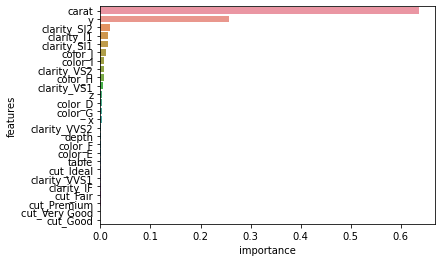

In [54]:
sns.barplot(x = "importance", y= "features", data = df_importance)

In [56]:
X_train.corr(method="spearman")

,carat,depth,table,x,y,z
carat,1.000000,0.032347,0.191737,0.996177,0.995587,0.992984
depth,0.032347,1.000000,-0.246866,-0.021041,-0.023261,0.105538
table,0.191737,-0.246866,1.000000,0.199331,0.193248,0.156810
x,0.996177,-0.021041,0.199331,1.000000,0.997913,0.987241
y,0.995587,-0.023261,0.193248,0.997913,1.000000,0.986802
z,0.992984,0.105538,0.156810,0.987241,0.986802,1.000000


### Permutation Feature importance

In [65]:
from sklearn.inspection import permutation_importance


X_test_transformed = grid.best_estimator_[0].transform(X_test)

In [67]:
perm_imp = permutation_importance(grid.best_estimator_[-1],
                                  X_test_transformed,
                                  y_test,
                                  scoring ="neg_mean_squared_error",
                                  n_repeats=20,
                                  random_state=42)

In [68]:
perm_imp['importances_mean']

array([-5.76702084e+02, -1.52600886e+02,  2.54654778e+04, -9.03821739e+02,
       -5.64315811e+02,  1.41283165e+05,  6.61686798e+04,  5.79097117e+04,
        1.14117860e+05,  2.52676340e+05,  4.61162808e+05,  6.28502837e+05,
        6.39323170e+05,  1.61957563e+04,  1.78214713e+06,  3.11965275e+06,
        2.55243929e+05,  5.93822638e+05,  1.81455178e+04,  8.12237747e+04,
        2.49632002e+07,  1.35159297e+04,  2.08164664e+03,  1.78300658e+06,
        4.69768601e+06,  2.68247776e+05])

In [70]:
df_importance = pd.DataFrame(perm_imp['importances_mean'], columns= ["importance"])
df_importance["features"] = feature_labels
df_importance.sort_values("importance", ascending=False,inplace=True)

<AxesSubplot:xlabel='importance', ylabel='features'>

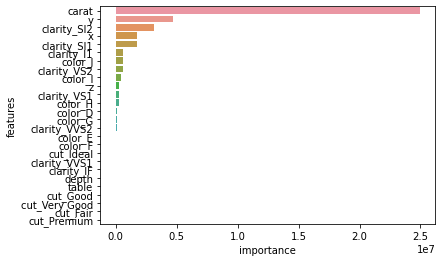

In [71]:
sns.barplot(x = "importance", y= "features", data = df_importance)